### Note book one

Compare the survey results for specific items indentified during shoreline surveillance of Lake Geneva. Group survey results in time by Winter, Spring, Summer or Fall, by body of water and municipality.

__Research question:__

_Does the data indicate that shoreline litter densities are seasonal? If so describe the relationship._

#### Contents

1. Setting up the environment with annaconda
2. Getting data   
3. Descriptives


### Setting up

Make sure you are running the same packages as this notebook. There is a requirements.txt file for the virutal environment in the [repo](https://github.com/hammerdirt/SWE_2019.git). 

If you spend more time managing the virtual environment than doing data stuff then try using Annaconda. It works good on all machines. [Anaconda](https://conda.io/projects/conda/en/latest/user-guide/index.html)

### Getting data

##### Imports

In [1]:
import numpy as np
import json
import csv
import datetime
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import requests
import os
import matplotlib.dates as mdates
from matplotlib import colors as mcolors
from matplotlib.ticker import MultipleLocator
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [2]:
# The data is off of the API at https://mwshovel.pythonanywhere.com/dirt/api_home.html 
# You will have the opportunity to save the data locally
# get some file structures in place 

folders = ["Data", "Charts", "Utilities"]
here = os.getcwd()
# This will make the directory structure for you
# !! Comment this out once you have ran it !!
# def makeDirectory():
#     for folder in folders:
#         place = here +"/"+ folder
#         os.mkdir(place)
# makeDirectory()      

# never comment this out -- it is used to save output
def make_folders():
    my_folders = {}
    for folder in folders:
        place = here +"/"+ folder
        my_folders[folder] = place
    return my_folders
my_folders = make_folders()

##### Requesting data

un familiar with python requests ? go to [Requests for humans](https://requests.kennethreitz.org//en/v1.1.0/)

In [3]:
# use requests.py to fetch the data from the API
# these are the endpoints to get all the data for the lake concerning Toys, Plastic Sheeting and the locations where 
# they were identified:
end_points = [
    "http://mwshovel.pythonanywhere.com/dirt/beaches/Lac-L%C3%A9man/",
    "http://mwshovel.pythonanywhere.com/dirt/codes/Lac-L%C3%A9man/G32",
    "http://mwshovel.pythonanywhere.com/dirt/codes/Lac-L%C3%A9man/G67",    
]
variable_names=["beach_info", "get_toys", "get_sheeting"]

def getTheData():
    data = {}
    for i, name in enumerate(variable_names):
        data[name] = requests.get(end_points[i])
    return data

# store all that in a dictionary
data = getTheData()
# to get that data in an array of dictionaries call .json() on the dictionary object you want
my_beach_info = data['beach_info'].json()
# take a look at the first entry
my_beach_info[0]

{'location': 'Anarchy-Beach',
 'latitude': '46.44721600',
 'longitude': '6.85961200',
 'city': 'La-Tour-de-Peilz',
 'post': '1814',
 'water': 'l',
 'water_name': 'Lac-Léman',
 'project_id': 'MCBP',
 'owner': 'mwshovel'}

In [4]:
# need to get the code data
# the mlw codes are located here https://mwshovel.pythonanywhere.com/dirt/beach_litter.html
# there is a button that says get data in CSV format
code_data = here +"/"+ "Data/mlw_code_defs.csv"
code_defs = pd.read_csv(code_data)

# this will output the code for Toys:
code_defs.loc[code_defs.code=="G32"]

,code,material,description,source
31,G32,Plastic,Toys and fireworks,Recreation


##### Data type and structure

In [5]:
# This is the data that describes one entry for the toys category
my_sheets = data["get_sheeting"].json()
my_toys = data["get_toys"].json()
my_toys[0]

{'location_id': 'Baye-de-Montreux-G',
 'date': '2015-11-23',
 'code_id': 'G32',
 'length': 61,
 'quantity': 4,
 'project_id': 'MCBP',
 'owner': 'mwshovel'}

### Descriptive statistics

In [6]:
# this can be done with or without pandas
# the end result is always sets of ordered pairs or clusters of sets of ordered pairs
# get the median, min, max, mean of pieces per meter
# get the total pieces number per location or grouping level
# get of # of samples, # of locations, intersection of locations
# compare those to the whole lake

In [7]:
# make a pieces per meter value for each observation
def get_pieces_per_meter(a_list_of_objects):
    new_list_of_objects = []
    for this_object in a_list_of_objects:
        new_object = this_object
        new_object["pcs_m"] = np.round(new_object["quantity"]/new_object["length"], 3)
        new_list_of_objects.append(new_object)
    return new_list_of_objects
sheetting_pcs_m = get_pieces_per_meter(my_sheets)
toys_pcs_m = get_pieces_per_meter(my_toys)

#### Decide wether or not to use pandas


##### depends on what you are doing

This data set is small enough that you d'ont need to anticipate any real heavy lifting. Getting descriptive statisitics and results over time is pretty simple with the data in dictionary format.

What we really want is a method that provides us with the responses to our questions and provides those responses in a way that can be passed on easily to other platforms for analysis and visualisation. 


In [8]:
# reminder of the basic unit and grouping levels:
sheetting_pcs_m[0]

{'location_id': 'Baye-de-Montreux-D',
 'date': '2015-12-04',
 'code_id': 'G67',
 'length': 61,
 'quantity': 4,
 'project_id': 'MCBP',
 'owner': 'mwshovel',
 'pcs_m': 0.066}

In [9]:
# get results as time value pairs:
def timeValuePairs(aList):
    myPairs = [[result['date'], result['pcs_m']] for result in aList]
    return myPairs
sheetting_time_value = timeValuePairs(sheetting_pcs_m)
toys_time_value = timeValuePairs(toys_pcs_m)

In [10]:
# get descriptives:
# get the median, max, min, average, 25th, 75th and no of samples
def describe_this(aList):
    results = {}
    pcs_m = []
    for result in aList:
        pcs_m.append(result["pcs_m"])
    results["the_min"], results["the_max"] = np.min(pcs_m), np.max(pcs_m)
    results["the_median"],results["the_average"] = np.median(pcs_m), np.mean(pcs_m)
    results["twenty_fifth"],results["seventy_fifth"] = np.percentile(pcs_m, 25), np.percentile(pcs_m, 75)
    results["no_samples"] = len(pcs_m)
    return results      

In [11]:
# print the stats so far:
print("Stats for toys")
print(describe_this(toys_pcs_m))
print("Stats for sheetting")
print(describe_this(sheetting_pcs_m))

Stats for toys
{'the_min': 0.012, 'the_max': 2.222, 'the_median': 0.062, 'the_average': 0.12794666666666665, 'twenty_fifth': 0.026500000000000003, 'seventy_fifth': 0.125, 'no_samples': 75}
Stats for sheetting
{'the_min': 0.014, 'the_max': 6.1, 'the_median': 0.23, 'the_average': 0.5678348623853211, 'twenty_fifth': 0.094, 'seventy_fifth': 0.556, 'no_samples': 109}


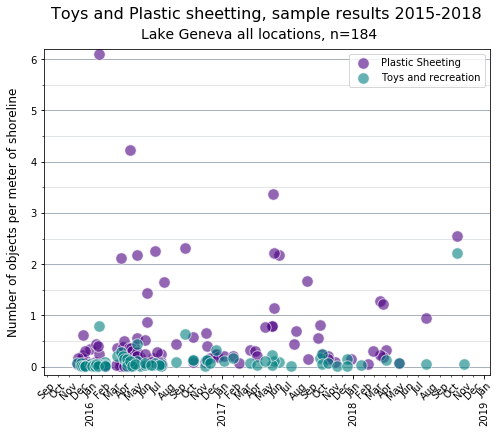

In [12]:
compare_these = [sheetting_time_value, toys_time_value]
color = ["indigo", "teal"]
labels = ["Plastic Sheeting", "Toys and recreation"]
save_to = my_folders["Charts"] +"/"+ "initialScatter.svg"

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_ymargin(0.01)
ax.set_axisbelow(True)
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')
monthsFmt = mdates.DateFormatter('%b')

ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)
ax.xaxis.set_minor_formatter(monthsFmt)
for text in ax.get_xminorticklabels()[::2]:
    text.set_visible(False)
ax.tick_params(axis='x', which="major", pad=22, labelrotation=90)
ax.tick_params(axis='x', which="minor", labelsize=10, labelrotation=45)
ml = MultipleLocator(.5)
ax.yaxis.set_minor_locator(ml)
num_samples = 0
for i, theList in enumerate(compare_these):
    num_samples += len(theList)
    for n,aPair in enumerate(theList):
        the_date = datetime.datetime.strptime(aPair[0], "%Y-%m-%d").date()
        ax.scatter(the_date,aPair[1], color=color[i], edgecolor="white",linewidth=1, s=130, alpha=0.6, label=labels[i] if n == 0 else "")
        
# lay down the gridlines
ax.grid(b=True, which='major', axis='y', linewidth=1, color='slategray', alpha=0.5)
ax.grid(b=True, which='minor', axis='y', linewidth=1, color='slategray', alpha=0.2)

plt.suptitle("Lake Geneva all locations, n=" + str(num_samples),
          fontsize=14, family='sans',horizontalalignment='center',  y =0.93)
ax.set_ylabel("Number of objects per meter of shoreline", labelpad= 10, color='black', fontsize=12)
plt.title("Toys and Plastic sheetting, sample results 2015-2018" ,
                 fontsize=16, family='sans', loc="center",pad=30,  y=1 )
plt.legend()
plt.savefig(save_to)

# ax.set_title('Volume and percent change')
# fig.tight_layout()
plt.show()
